# Rockfall Hazard Prediction: Data Analysis and Cleaning

This notebook provides comprehensive data analysis and cleaning for rockfall hazard prediction. We'll explore the dataset, perform correlation analysis, handle data quality issues, and prepare the data for machine learning modeling.

## Objectives:
1. **Data Exploration**: Understand the structure and characteristics of the rockfall dataset
2. **Data Cleaning**: Handle missing values, outliers, and data quality issues
3. **Correlation Analysis**: Identify relationships between features and target variables
4. **Feature Engineering Integration**: Apply feature engineering to create normalized risk scores
5. **Data Preparation**: Prepare clean data for machine learning models

## Dataset Overview:
The dataset contains rockfall hazard data with geological, meteorological, and risk assessment features including:
- **Geological features**: slope angle, roughness, curvature, relief
- **Environmental features**: weather data, temperature, precipitation
- **Risk features**: risk probability (7-day) and risk severity
- **Target**: Hazard score (risk_probability_normalized × risk_severity_normalized)

## 1. Import Required Libraries

In [1]:
# Import essential libraries for data analysis and machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Statistical analysis
from scipy import stats
from scipy.stats import pearsonr, spearmanr

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Feature engineering (our custom module)
import sys
sys.path.append('.')
from feature_engineering import RockfallFeatureEngineer

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"XGBoost version: {xgb.__version__}")

Libraries imported successfully!
Pandas version: 2.3.2
NumPy version: 2.3.3
XGBoost version: 3.0.5


## 2. Load and Explore Dataset

In [2]:
# Load the dataset
data_file = "Rock_fall_dataset - advanced_rockfall_dataset.csv"
df = pd.read_csv(data_file)

print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Number of features: {df.shape[1]}")
print(f"Number of samples: {df.shape[0]}")

# Display basic information about the dataset
print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Dataset info:")
df.info()

Dataset loaded successfully!
Dataset shape: (60000, 31)
Number of features: 31
Number of samples: 60000

DATASET OVERVIEW
Memory usage: 14.19 MB
Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   slope_angle          60000 non-null  float64
 1   slope_roughness      60000 non-null  float64
 2   seeder_height        60000 non-null  float64
 3   aspect_sin           60000 non-null  float64
 4   aspect_cos           60000 non-null  float64
 5   curvature            60000 non-null  float64
 6   local_relief         60000 non-null  float64
 7   roughness_m          60000 non-null  float64
 8   roughness_l          60000 non-null  float64
 9   kinetic_energy       60000 non-null  float64
 10  impact_position      60000 non-null  float64
 11  runout_distance      60000 non-null  float64
 12  rain_1d_mm           60000 

In [3]:
# Display first few rows
print("First 5 rows of the dataset:")
print(df.head())

print("\n" + "="*50)
print("COLUMN NAMES AND DATA TYPES")
print("="*50)
for i, (col, dtype) in enumerate(zip(df.columns, df.dtypes)):
    print(f"{i+1:2d}. {col:25s} - {dtype}")

print(f"\nTotal columns: {len(df.columns)}")

First 5 rows of the dataset:
   slope_angle  slope_roughness  seeder_height  aspect_sin  aspect_cos  curvature  local_relief  roughness_m  roughness_l  kinetic_energy  impact_position  runout_distance  rain_1d_mm  rain_3d_mm  rain_7d_mm  rain_30d_mm     api_7d    api_30d  temp_mean_7d_c  temp_min_7d_c  temp_max_7d_c  freeze_thaw_7d  vibration_events_7d  vibration_rms_24h  disp_rate_mm_day  disp_accel_mm_day2  pore_pressure_kpa  pore_trend_kpa_day  strain_rate_micro  risk_prob_7d  risk_severity
0    43.130544        10.791626      36.596796    0.966372   -0.257147  -0.015481     43.766012    11.531071    14.088965      291.266996        39.110101        61.694855   15.993804   17.097140   17.733938    64.644996  17.368885  41.006941        7.120993       0.792230      13.449756        0.867645                    4           0.011357          0.337239           -0.141234          47.196734           -0.381401           0.271377      0.267023       0.347154
1    50.586560         4.606407

In [4]:
# Basic statistical summary
print("BASIC STATISTICAL SUMMARY")
print("="*50)
print(df.describe().round(4))

BASIC STATISTICAL SUMMARY
       slope_angle  slope_roughness  seeder_height  aspect_sin  aspect_cos   curvature  local_relief  roughness_m  roughness_l  kinetic_energy  impact_position  runout_distance  rain_1d_mm  rain_3d_mm  rain_7d_mm  rain_30d_mm      api_7d     api_30d  temp_mean_7d_c  temp_min_7d_c  temp_max_7d_c  freeze_thaw_7d  vibration_events_7d  vibration_rms_24h  disp_rate_mm_day  disp_accel_mm_day2  pore_pressure_kpa  pore_trend_kpa_day  strain_rate_micro  risk_prob_7d  risk_severity
count   60000.0000       60000.0000     60000.0000  60000.0000  60000.0000  60000.0000    60000.0000   60000.0000   60000.0000      60000.0000       60000.0000       60000.0000  60000.0000  60000.0000  60000.0000   60000.0000  60000.0000  60000.0000      60000.0000     60000.0000     60000.0000      60000.0000           60000.0000         60000.0000        60000.0000          60000.0000         60000.0000          60000.0000         60000.0000    60000.0000     60000.0000
mean       54.9928  

## 3. Data Cleaning and Preprocessing

In [5]:
# Check for missing values
print("MISSING VALUES ANALYSIS")
print("="*50)
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_info = pd.DataFrame({
    'Column': missing_values.index,
    'Missing_Count': missing_values.values,
    'Missing_Percentage': missing_percentage.values
})

# Filter out columns with no missing values for cleaner display
missing_info = missing_info[missing_info['Missing_Count'] > 0]

if len(missing_info) > 0:
    print("Columns with missing values:")
    print(missing_info.to_string(index=False))
else:
    print("✓ No missing values found in the dataset!")

print(f"\nTotal missing values: {df.isnull().sum().sum()}")
print(f"Percentage of complete rows: {(len(df) - df.isnull().any(axis=1).sum()) / len(df) * 100:.2f}%")

MISSING VALUES ANALYSIS
✓ No missing values found in the dataset!

Total missing values: 0
Percentage of complete rows: 100.00%


In [6]:
# Check for duplicate rows
print("DUPLICATE ANALYSIS")
print("="*50)
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
print(f"Percentage of duplicates: {duplicates / len(df) * 100:.2f}%")

if duplicates > 0:
    print("\nRemoving duplicate rows...")
    df_cleaned = df.drop_duplicates()
    print(f"Rows after removing duplicates: {len(df_cleaned)}")
    print(f"Removed {len(df) - len(df_cleaned)} duplicate rows")
    df = df_cleaned
else:
    print("✓ No duplicate rows found!")

DUPLICATE ANALYSIS
Number of duplicate rows: 0
Percentage of duplicates: 0.00%
✓ No duplicate rows found!


In [7]:
# Outlier detection using IQR method
def detect_outliers_iqr(data, column):
    """Detect outliers using IQR method"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

print("OUTLIER ANALYSIS")
print("="*50)

# Analyze outliers for key numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns
outlier_summary = []

for col in numerical_cols:
    outliers, lower, upper = detect_outliers_iqr(df, col)
    outlier_count = len(outliers)
    outlier_percentage = (outlier_count / len(df)) * 100
    
    outlier_summary.append({
        'Column': col,
        'Outlier_Count': outlier_count,
        'Outlier_Percentage': round(outlier_percentage, 2),
        'Lower_Bound': round(lower, 4),
        'Upper_Bound': round(upper, 4)
    })

outlier_df = pd.DataFrame(outlier_summary)
outlier_df = outlier_df[outlier_df['Outlier_Count'] > 0].sort_values('Outlier_Percentage', ascending=False)

if len(outlier_df) > 0:
    print("Columns with outliers (sorted by percentage):")
    print(outlier_df.to_string(index=False))
else:
    print("✓ No outliers detected using IQR method!")

OUTLIER ANALYSIS
Columns with outliers (sorted by percentage):
             Column  Outlier_Count  Outlier_Percentage  Lower_Bound  Upper_Bound
  strain_rate_micro           3219                5.37      -0.3150       1.1364
     freeze_thaw_7d           3147                5.24      -1.8374       3.0623
   disp_rate_mm_day           2819                4.70      -1.0685       2.2335
         rain_1d_mm           2574                4.29      -6.4512      14.6310
         rain_3d_mm           1866                3.11      -9.9483      28.0848
    impact_position           1672                2.79     -23.7125      66.6349
         rain_7d_mm           1419                2.37     -13.0212      46.7366
             api_7d           1180                1.97      -6.6615      33.9323
        rain_30d_mm           1154                1.92     -17.7023      94.3937
            api_30d            946                1.58      -6.4421      59.1657
       risk_prob_7d            663            

## 4. Exploratory Data Analysis (EDA)

DISTRIBUTION ANALYSIS


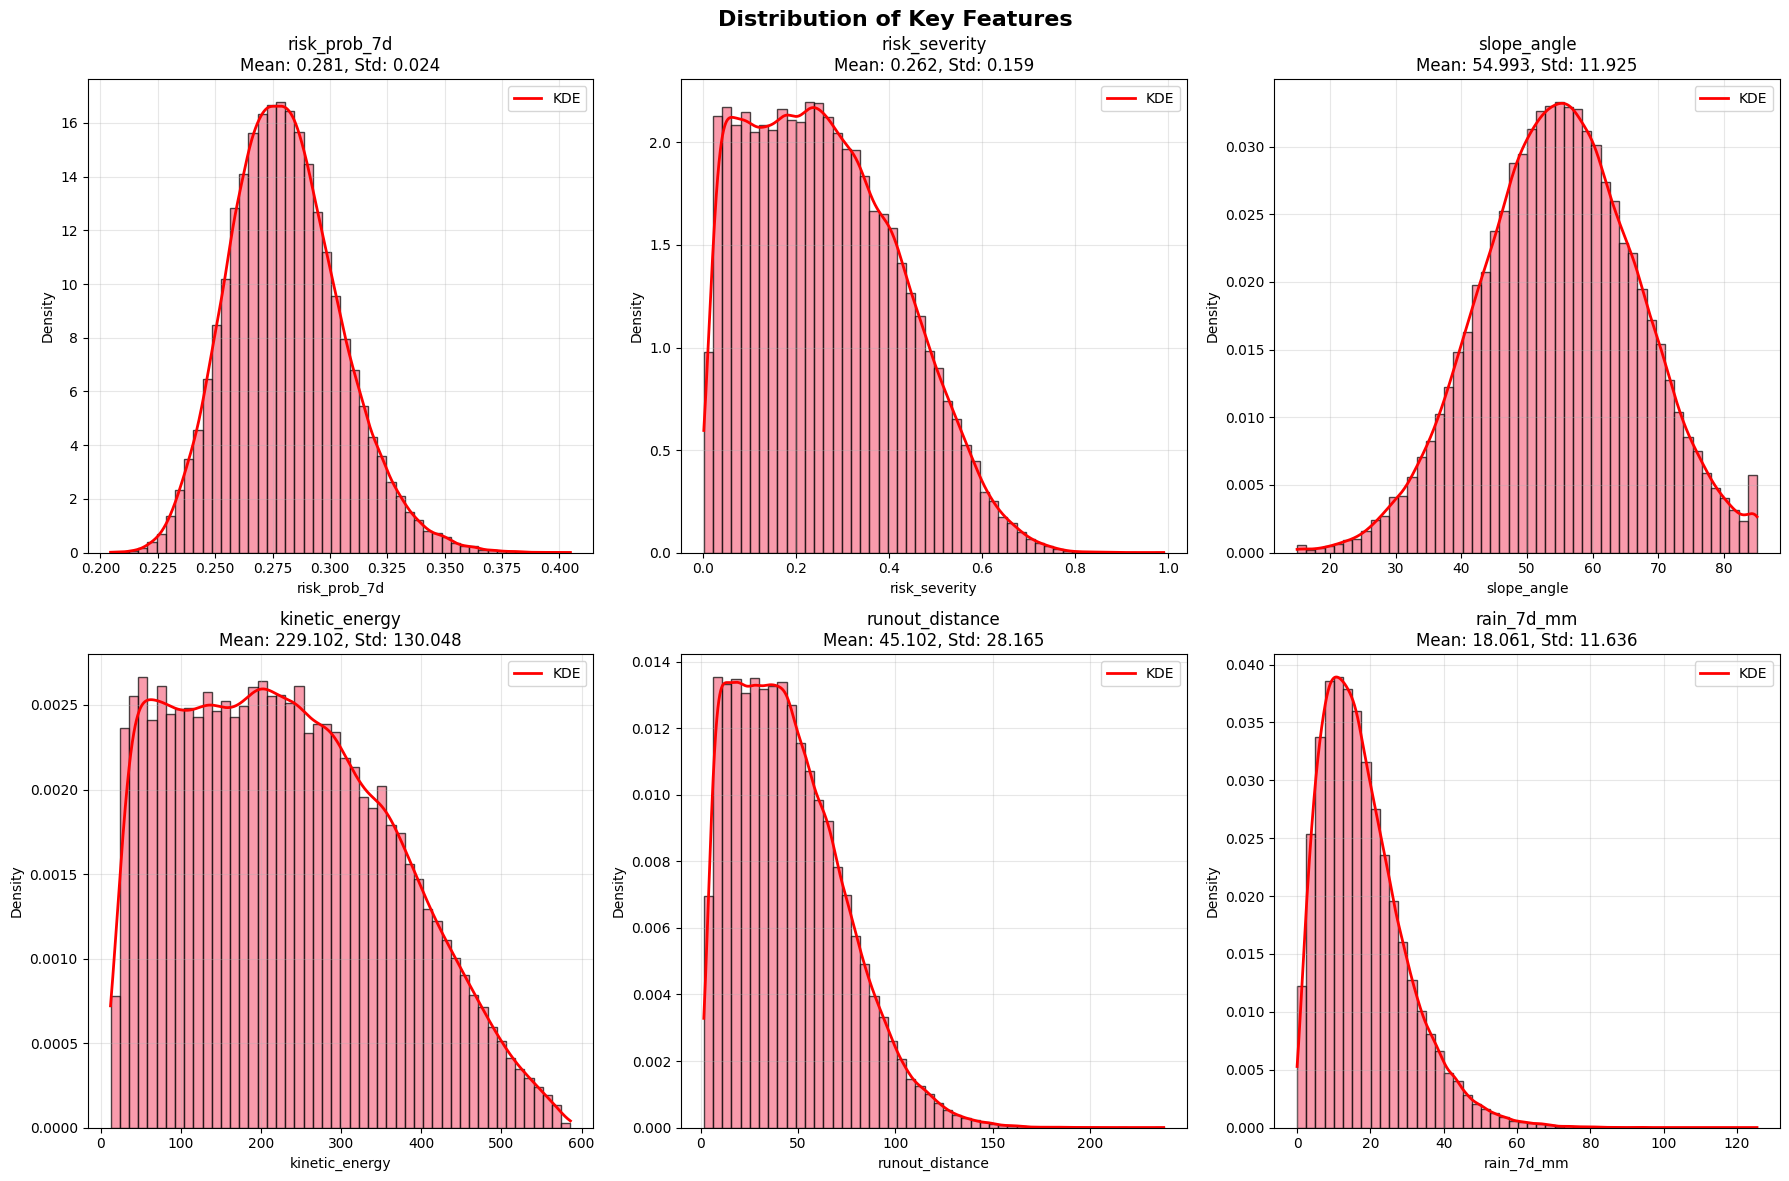


Distribution Statistics for Key Features:
risk_prob_7d        : Skewness =  0.407, Kurtosis =  0.288
risk_severity       : Skewness =  0.422, Kurtosis = -0.538
slope_angle         : Skewness = -0.038, Kurtosis = -0.134
kinetic_energy      : Skewness =  0.337, Kurtosis = -0.745
runout_distance     : Skewness =  0.750, Kurtosis =  0.366
rain_7d_mm          : Skewness =  1.138, Kurtosis =  1.925


In [8]:
# Distribution analysis of key features
print("DISTRIBUTION ANALYSIS")
print("="*50)

# Create subplots for key feature distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Distribution of Key Features', fontsize=16, fontweight='bold')

# Key features to analyze
key_features = ['risk_prob_7d', 'risk_severity', 'slope_angle', 'kinetic_energy', 'runout_distance', 'rain_7d_mm']

for i, feature in enumerate(key_features):
    row = i // 3
    col = i % 3
    
    # Histogram with KDE
    axes[row, col].hist(df[feature], bins=50, alpha=0.7, density=True, edgecolor='black')
    
    # Add KDE curve
    data_sorted = np.sort(df[feature])
    kde = stats.gaussian_kde(df[feature])
    axes[row, col].plot(data_sorted, kde(data_sorted), 'r-', linewidth=2, label='KDE')
    
    axes[row, col].set_title(f'{feature}\nMean: {df[feature].mean():.3f}, Std: {df[feature].std():.3f}')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Density')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print distribution statistics
print("\nDistribution Statistics for Key Features:")
for feature in key_features:
    skewness = stats.skew(df[feature])
    kurtosis = stats.kurtosis(df[feature])
    print(f"{feature:20s}: Skewness = {skewness:6.3f}, Kurtosis = {kurtosis:6.3f}")

RISK FEATURES ANALYSIS


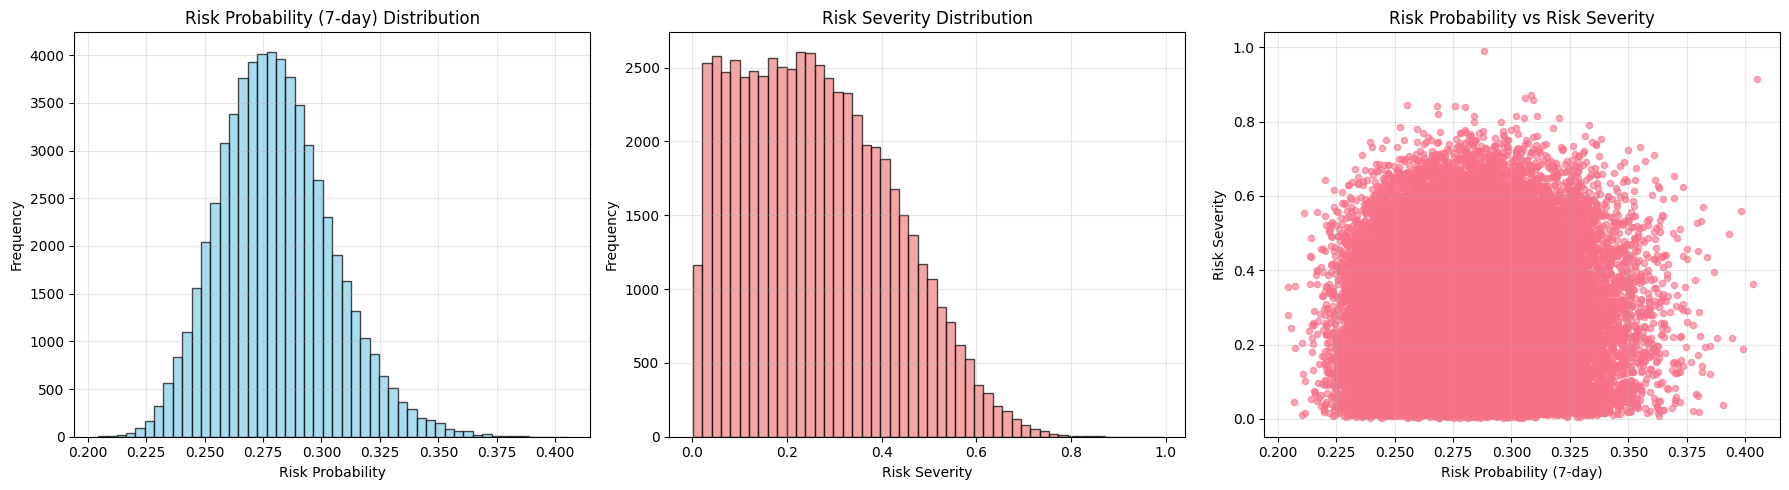


Correlation between Risk Probability and Risk Severity: 0.0381

Risk Probability Statistics:
  Range: [0.2044, 0.4048]
  Mean: 0.2806
  Std: 0.0240

Risk Severity Statistics:
  Range: [0.0014, 0.9908]
  Mean: 0.2617
  Std: 0.1586


In [9]:
# Risk features analysis
print("RISK FEATURES ANALYSIS")
print("="*50)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Risk probability distribution
axes[0].hist(df['risk_prob_7d'], bins=50, alpha=0.7, edgecolor='black', color='skyblue')
axes[0].set_title('Risk Probability (7-day) Distribution')
axes[0].set_xlabel('Risk Probability')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

# Risk severity distribution
axes[1].hist(df['risk_severity'], bins=50, alpha=0.7, edgecolor='black', color='lightcoral')
axes[1].set_title('Risk Severity Distribution')
axes[1].set_xlabel('Risk Severity')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

# Scatter plot of risk probability vs severity
scatter = axes[2].scatter(df['risk_prob_7d'], df['risk_severity'], alpha=0.6, s=20)
axes[2].set_title('Risk Probability vs Risk Severity')
axes[2].set_xlabel('Risk Probability (7-day)')
axes[2].set_ylabel('Risk Severity')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate correlation between risk features
risk_corr = df[['risk_prob_7d', 'risk_severity']].corr()
print(f"\nCorrelation between Risk Probability and Risk Severity: {risk_corr.iloc[0,1]:.4f}")

print(f"\nRisk Probability Statistics:")
print(f"  Range: [{df['risk_prob_7d'].min():.4f}, {df['risk_prob_7d'].max():.4f}]")
print(f"  Mean: {df['risk_prob_7d'].mean():.4f}")
print(f"  Std: {df['risk_prob_7d'].std():.4f}")

print(f"\nRisk Severity Statistics:")
print(f"  Range: [{df['risk_severity'].min():.4f}, {df['risk_severity'].max():.4f}]")
print(f"  Mean: {df['risk_severity'].mean():.4f}")
print(f"  Std: {df['risk_severity'].std():.4f}")

## 5. Correlation Analysis

CORRELATION ANALYSIS


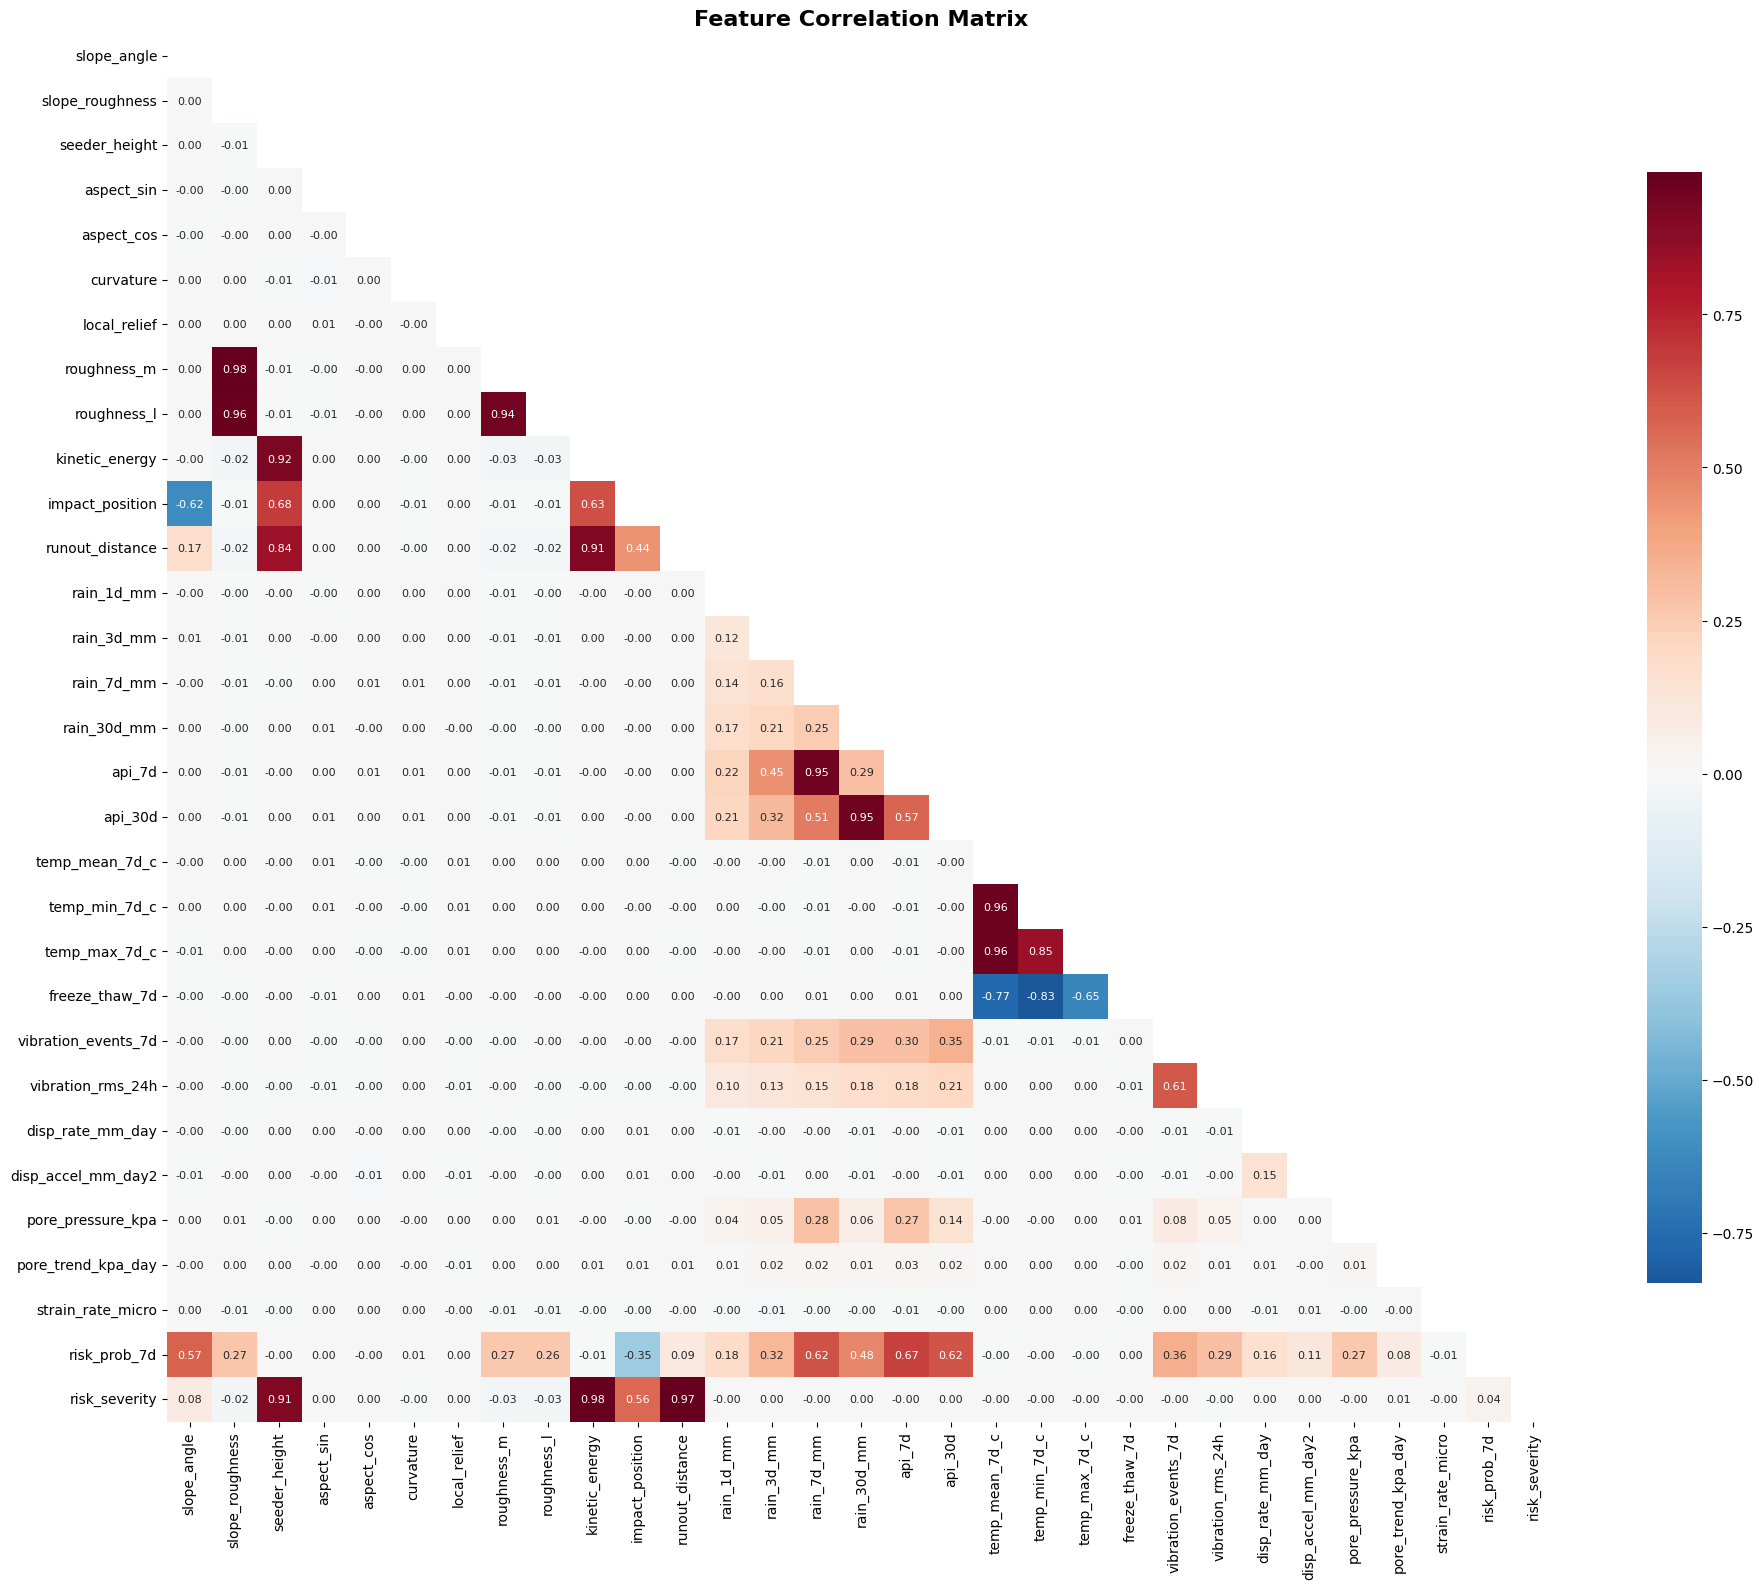

Correlation matrix shape: (31, 31)


In [10]:
# Calculate correlation matrix
print("CORRELATION ANALYSIS")
print("="*50)

# Calculate Pearson correlation matrix
correlation_matrix = df.corr()

# Create correlation heatmap
plt.figure(figsize=(20, 16))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='RdBu_r', 
            center=0,
            square=True,
            mask=mask,
            cbar_kws={"shrink": 0.8},
            fmt='.2f',
            annot_kws={'size': 8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Correlation matrix shape: {correlation_matrix.shape}")

In [11]:
# Analyze correlations with risk features
print("CORRELATION WITH RISK FEATURES")
print("="*50)

# Get correlations with risk_prob_7d
prob_correlations = correlation_matrix['risk_prob_7d'].abs().sort_values(ascending=False)
print("Top 10 features correlated with Risk Probability:")
for i, (feature, corr) in enumerate(prob_correlations.head(10).items()):
    print(f"{i+1:2d}. {feature:25s}: {corr:6.4f}")

print("\n" + "-"*50)

# Get correlations with risk_severity
severity_correlations = correlation_matrix['risk_severity'].abs().sort_values(ascending=False)
print("Top 10 features correlated with Risk Severity:")
for i, (feature, corr) in enumerate(severity_correlations.head(10).items()):
    print(f"{i+1:2d}. {feature:25s}: {corr:6.4f}")

# Identify highly correlated feature pairs (potential multicollinearity)
print("\n" + "="*50)
print("HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.8)")
print("="*50)

high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.8:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_value))

if high_corr_pairs:
    for feature1, feature2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f"{feature1:25s} - {feature2:25s}: {corr:6.4f}")
else:
    print("No highly correlated feature pairs found (threshold: |r| > 0.8)")

CORRELATION WITH RISK FEATURES
Top 10 features correlated with Risk Probability:
 1. risk_prob_7d             : 1.0000
 2. api_7d                   : 0.6657
 3. rain_7d_mm               : 0.6241
 4. api_30d                  : 0.6199
 5. slope_angle              : 0.5719
 6. rain_30d_mm              : 0.4769
 7. vibration_events_7d      : 0.3581
 8. impact_position          : 0.3527
 9. rain_3d_mm               : 0.3233
10. vibration_rms_24h        : 0.2936

--------------------------------------------------
Top 10 features correlated with Risk Severity:
 1. risk_severity            : 1.0000
 2. kinetic_energy           : 0.9824
 3. runout_distance          : 0.9716
 4. seeder_height            : 0.9052
 5. impact_position          : 0.5603
 6. slope_angle              : 0.0781
 7. risk_prob_7d             : 0.0381
 8. roughness_l              : 0.0253
 9. roughness_m              : 0.0252
10. slope_roughness          : 0.0244

HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.8)
kinetic_energy 